This notebook plots some statistics of the atmospheric turbulence

In [1]:
from utils.atm_stat import AtmStat

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lsst.ts.phosim.utils.ConvertZernikesToPsfWidth import convertZernikesToPsfWidth


First let's comprae the Kolmogorov and von Karman structure functions:

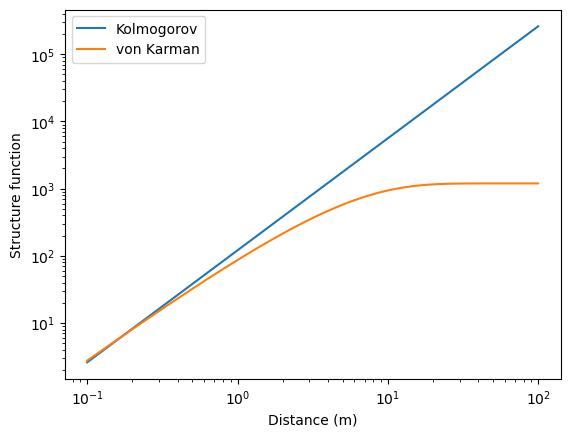

In [2]:
fig, ax = plt.subplots()

r = np.linspace(1e-1, 100, 10000)

atmStat = AtmStat()

# Kolmogorov
atmStat.set_params(L0=np.inf)
ax.plot(r, atmStat.structure(r), label="Kolmogorov")

# van Karman
atmStat.set_params(L0=30)
ax.plot(r, atmStat.structure(r), label="von Karman")

ax.set(xscale="log", yscale="log", xlabel="Distance (m)", ylabel="Structure function")
ax.legend()

plt.show()


Now let's plot the Zernike covariance:

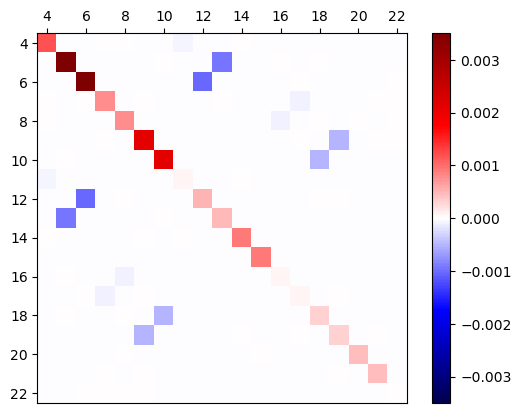

In [3]:
fig, ax = plt.subplots()

atmStat = AtmStat()
pos = ax.imshow(
    atmStat.zk_cov(),
    extent=(3.5, 22.5, 3.5, 22.5),
    vmin=-0.0035,
    vmax=+0.0035,
    cmap="seismic",
)
fig.colorbar(pos)
ax.set(
    xticks=np.arange(4, 23, 2),
    yticks=np.arange(4, 23, 2),
    yticklabels=np.arange(4, 23, 2)[::-1],
)
ax.xaxis.tick_top()

plt.show()


and the standard deviation of each Zernike:

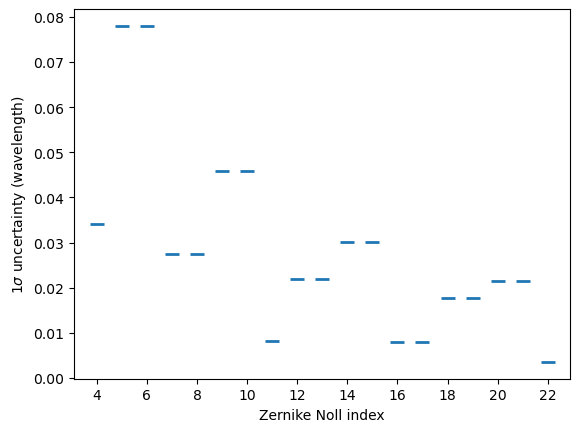

In [4]:
fig, ax = plt.subplots()

atmStat = AtmStat(pupil_N=250)
ax.scatter(np.arange(4, 23), atmStat.zk_std(), marker="_", s=100, lw=2)
ax.set(
    xlabel="Zernike Noll index",
    xticks=np.arange(4, 23, 2),
    ylabel="1$\sigma$ uncertainty (wavelength)",
)

plt.show()


Now let's investigate the cross-covariance for different lines of sight:

In [5]:
atmStat = AtmStat()
theta_covs = []
for theta in [0, 1, 2, 4, 8]:
    atmStat.set_params(theta=theta)
    theta_covs.append(atmStat.zk_cov())


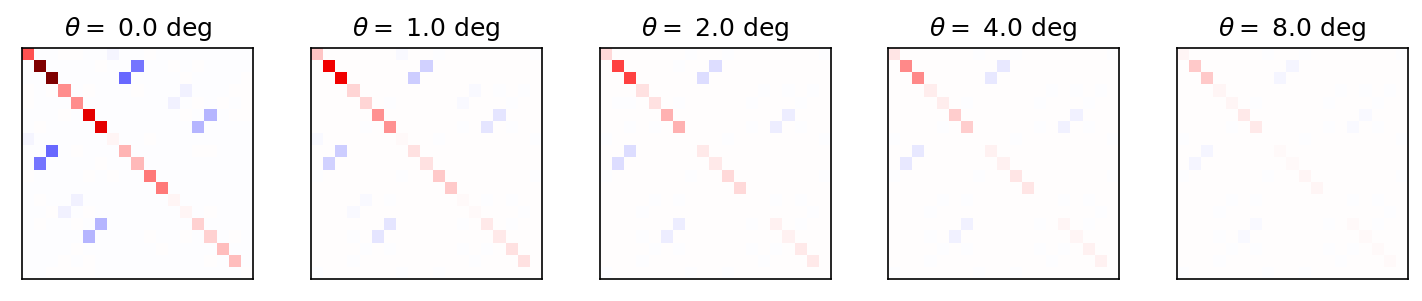

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2), dpi=150)

for i, theta in enumerate([0, 1, 2, 4, 8]):
    axes[i].imshow(
        theta_covs[i],
        vmin=-0.0035,
        vmax=+0.0035,
        cmap="seismic",
    )
    axes[i].set(xticks=[], yticks=[], title=f"$\\theta =$ {theta:.1f} deg")

plt.show()


Let's calculate the Zernike RMSE as a function of the angle between two lines of sight:

In [7]:
theta = np.concatenate(
    (
        np.linspace(0, 0.3, 20),
        np.linspace(0.3, 10, 81)[1:],
    )
)
theta_std = []

atmStat = AtmStat()
for th in theta:
    atmStat.set_params(theta=th)
    theta_std.append(atmStat.zk_std())

theta_std = np.array(theta_std)


In [8]:
RMSE_mean = np.sqrt(0.5 * np.sum(theta_std[0] ** 2 + theta_std**2, axis=1))
RMSE_std = np.sqrt(0.25 * np.sum(2 * theta_std[0] ** 4 + theta_std**4, axis=1))

rel_err_mean = RMSE_mean / RMSE_mean[0]
rel_err_std = RMSE_std / RMSE_mean[0]


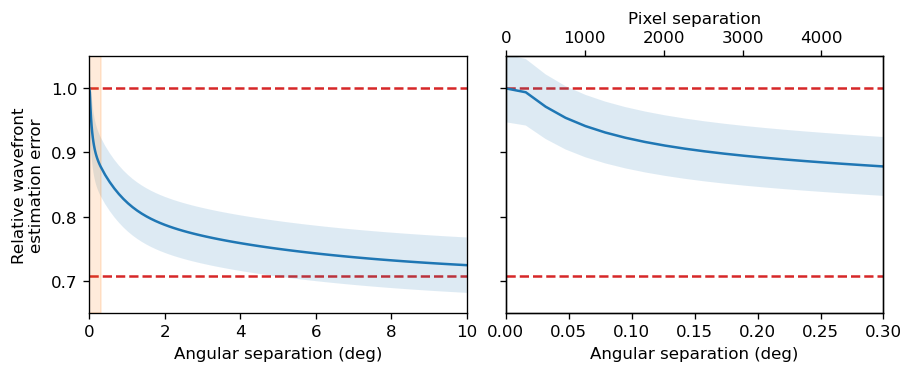

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 3), constrained_layout=True, dpi=120)

# full-view panel
ax1.plot(theta, rel_err_mean)
ax1.fill_between(
    theta,
    rel_err_mean - rel_err_std,
    rel_err_mean + rel_err_std,
    alpha=0.15,
)
ax1.set(
    xlabel="Angular separation (deg)",
    ylabel="Relative wavefront\nestimation error",
    xlim=(theta.min(), theta.max()),
    ylim=(0.65, 1.05),
)
ax1.axhline(1, c="C3", ls="--", zorder=0)
ax1.axhline(1 / np.sqrt(2), c="C3", ls="--", zorder=0)

# zoom-in panel
ax2.plot(theta, rel_err_mean)
ax2.fill_between(
    theta,
    rel_err_mean - rel_err_std,
    rel_err_mean + rel_err_std,
    alpha=0.15,
)
ax2.set(
    xlabel="Angular separation (deg)",
    xlim=(theta.min(), 0.3),
    ylim=ax1.get_ylim(),
    yticklabels=[],
)
ax2.axhline(1, c="C3", ls="--", zorder=0)
ax2.axhline(1 / np.sqrt(2), c="C3", ls="--", zorder=0)

# add a pixel axis to the zoom-in plot
ax2t = ax2.twiny()
ax2t.set_xlim(ax2.get_xlim())
ax1.axvspan(*ax2t.get_xlim(), color="C1", alpha=0.15)

pixel_ticks = np.arange(0, 5_000, 1000)
pixel_width = 0.2 / 3600  # degrees
pixel_diam = 2 * np.sqrt(pixel_width**2 / np.pi)
ax2t.set_xticks(pixel_ticks * pixel_diam)
ax2t.set_xticklabels(pixel_ticks)
ax2t.set(xlabel="Pixel separation")


plt.show()


Now let's calculate some statistics for the paper:

In [10]:
atmStat = AtmStat(
    Cn2=(
        (0.2, 2.58, 5.16, 7.73, 12.89, 15.46),
        (0.652, 0.172, 0.055, 0.025, 0.074, 0.022),
    ),
)


In [12]:
test_set = pd.read_pickle("data/test_dataframe.pkl")


In [14]:
test_set.columns


Index(['pntId', 'obsId', 'objId', 'ra', 'dec', 'fx', 'fy', 'corner', 'intra',
       'mag', 'filter', 'seeing', 'airmass', 'skyBrightness', 'blendMags',
       'blendOffsets', 'image', 'zernikes', 'dof', 'brightBlendOffsets'],
      dtype='object')

In [21]:
x = test_set[["filter", "seeing", "airmass"]].drop_duplicates()
x


,filter,seeing,airmass
0,u,0.937460,1.073287
18,y,0.476743,1.389459
35,u,0.839493,1.319268
63,r,0.327570,1.165100
95,r,0.521054,1.237357
156,g,0.585393,1.154666
179,g,0.732401,1.396232
211,z,0.980993,1.445578
264,i,0.762742,1.324965
296,y,0.681788,1.201653


In [2]:
obs_table = pd.read_parquet(
    "/astro/store/epyc/users/jfc20/data/aos_sims/observations.parquet"
)
obs_table = obs_table[["lsstFilter", "airmass", "seeingFwhm500"]]


In [3]:
atmStat = AtmStat()

atm_std = []
for _, row in obs_table.sample(1_000, random_state=42).iterrows():
    atmStat.set_params(
        wavelength=row["lsstFilter"],
        seeing=row["seeingFwhm500"],
        zenith=np.rad2deg(np.arccos(1 / row["airmass"])),
    )
    atm_std.append(atmStat.zk_std())

atm_std = np.array(atm_std)


In [8]:
np.save("data/atm_errs_new.npy", atm_std)


Text(0.5, 0, 'Error (arcsecs)')

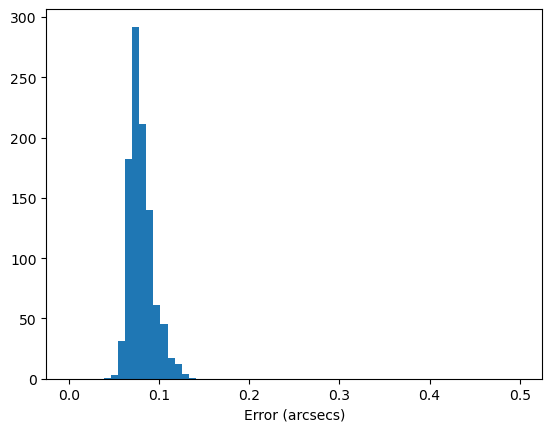

In [9]:
plt.hist(
    np.sqrt(np.sum(np.square(convertZernikesToPsfWidth(atm_std)), axis=1)),
    bins=64,
    range=(0, 0.5),
)
plt.xlabel("Error (arcsecs)")
